In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
import numba

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
current_dir = os.getcwd()
src_path = os.path.join(current_dir, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)

import viz
import grid
import cell
import FVM
import analytical

In [6]:
LEFT = np.array([1.0, 0.0, 1.0])
RIGHT = np.array([0.125, 0.0, 0.1])

x_diaphragm = 0.5

#  [rho_L, u_L, P_L, rho_R, u_R, P_R, gamma, x_diaphragm] for plotting analytical solution
init_con = np.concatenate([LEFT, RIGHT, np.array([FVM.get_gamma(), x_diaphragm])])

def init_grid(grid):
    """
    Initializes the primitive variables of the grid cells for the Sod Shock Tube problem.
    This function directly sets primitive values on cells.
    """
    active_cells = grid.get_all_active_cells()

    if not active_cells:
        print("No active cells found to initialize.")
        return

    cell_x_coords = np.array([cell.x for cell in active_cells])


    # Iterate through active cells and set their primitive variables directly
    for i, cell in enumerate(active_cells):
        if cell_x_coords[i] < x_diaphragm:
            cell.prim = list(LEFT)
        else:
            cell.prim = list(RIGHT)

In [7]:
def calc_MSE(history):
    def MSE(data1, data2):
        tmp = np.sum((data1 - data2) ** 2)
        return tmp / len(data1)
    
    grid_cells = history[-1].get_all_active_cells()

    X = np.array([c.x for c in grid_cells])
    t = history[-1].t
    grid_solution = np.array([c.prim for c in grid_cells])
    
    rho_numeric = grid_solution[:, 0]
    u_numeric = grid_solution[:, 1]
    P_numeric = grid_solution[:, 2]
    rho_analytic, u_analytic, P_analytic = analytical.get_sod_solution(X, t, *init_con)

    rho_MSE = MSE(rho_numeric, rho_analytic)
    u_MSE = MSE(u_numeric, u_analytic)
    P_MSE = MSE(P_numeric, P_analytic)

    return np.array([rho_MSE, u_MSE, P_MSE])

In [147]:
grid1 = grid.grid(L=1, N=50)
grid1.max_level = 3
start = time.time()
refine_epsilon = 10 ** -3
init_grid(grid1)
grid1_history = FVM.new_solve(FVM.HLL_flux, grid1, t_final=0.2, epsilon=refine_epsilon, dt_type='euler', dx_type="MUSCL")

print(len(grid1_history))
viz.plot_amr_grid(grid1)
viz.plot_amr_value(grid1, analytic=init_con)
print(time.time() - start)
print(f"MSE: {np.average(calc_MSE(grid1_history))}")
#viz.animate(grid1_history, 'plot/test.gif')

Using MUSCL in spatial and rk4 in temporal.


Solving Simulation:  55%|█████▌    | 0.11083510691180844/0.2 [00:07<00:06, 69.70s/s] 


KeyboardInterrupt: 

Using PPM in spatial and euler in temporal.


Solving Simulation: 100%|██████████| 0.2/0.2 [00:04<00:00, 20.17s/s]                 


FINISHED
340
4.177459955215454
MSE: 0.0010219404626966298


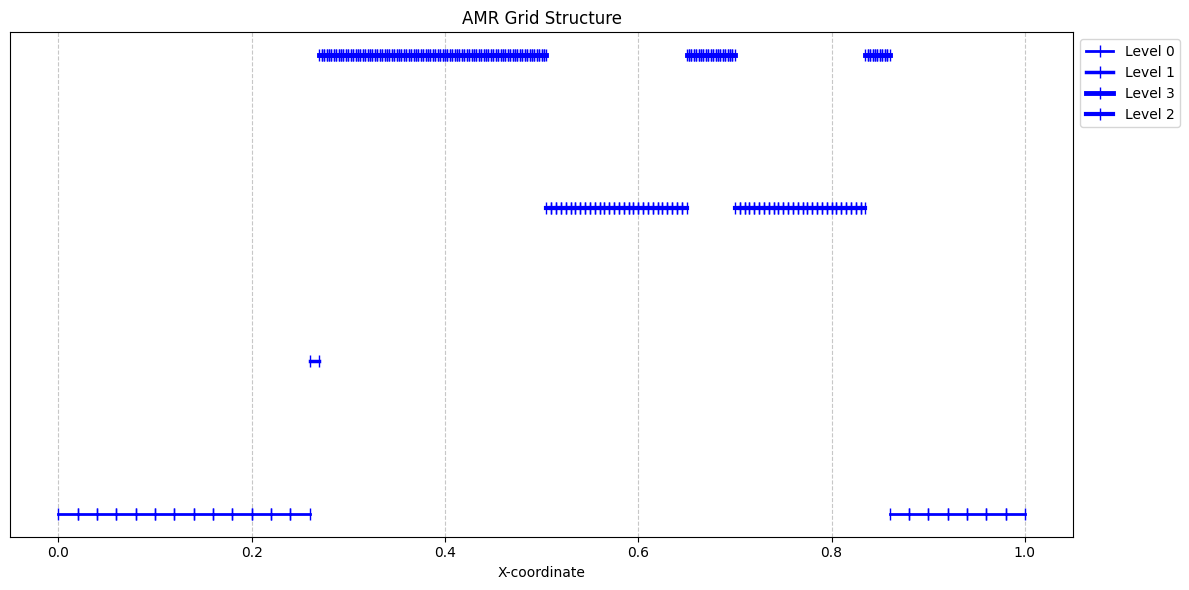

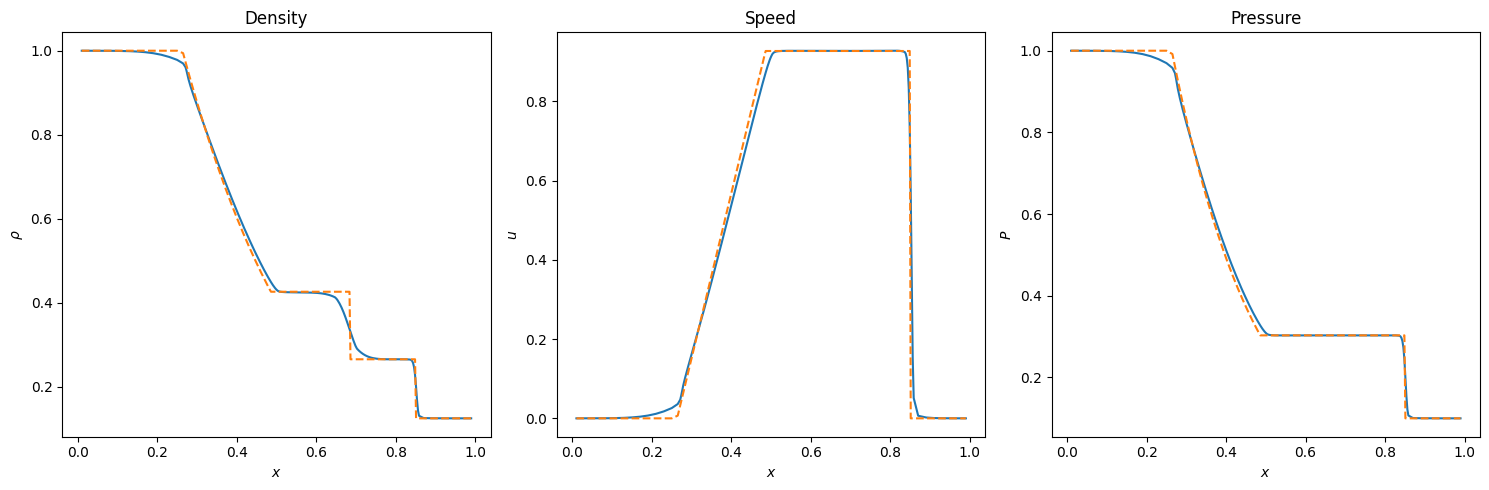

In [146]:
grid1 = grid.grid(L=1, N=50)
grid1.max_level = 3
start = time.time()
refine_epsilon = 10 ** -3
init_grid(grid1)
grid1_history = FVM.new_solve(FVM.HLL_flux, grid1, t_final=0.2, epsilon=refine_epsilon, dt_type='euler', dx_type="PPM")

print(len(grid1_history))
viz.plot_amr_grid(grid1)
viz.plot_amr_value(grid1, analytic=init_con)
print(time.time() - start)
print(f"MSE: {np.average(calc_MSE(grid1_history))}")
#viz.animate(grid1_history, 'plot/test.gif')

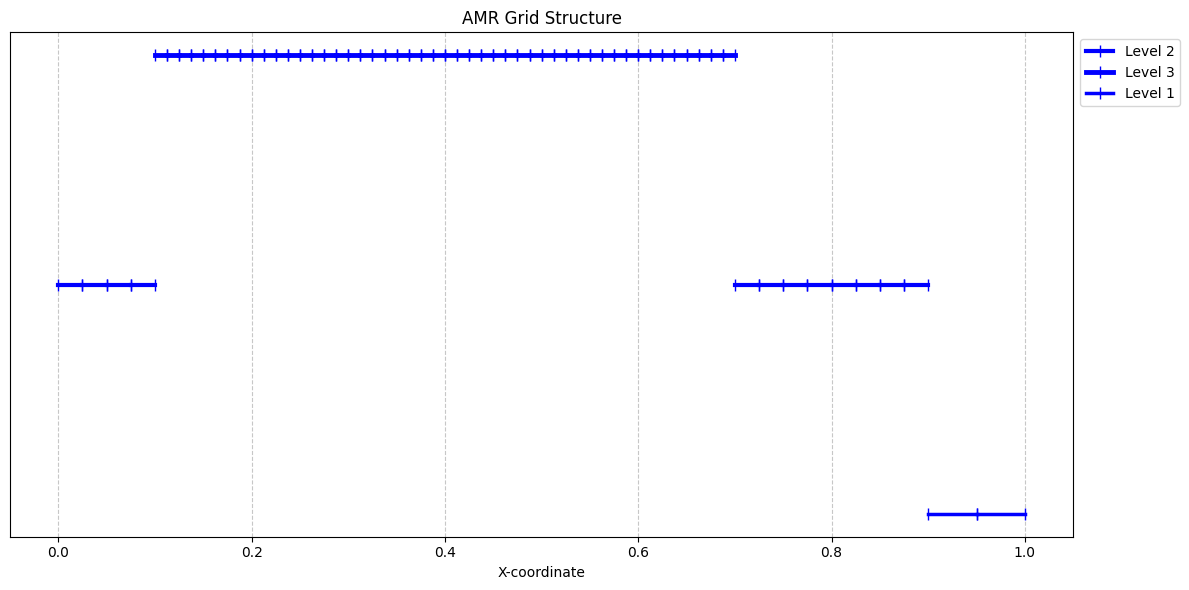

In [129]:
#viz.plot_amr_grid(grid1)
viz.plot_amr_grid(grid1)

Preparing animation with 200 frames for display...


100%|█████████▉| 199/200 [00:39<00:00,  5.04it/s]

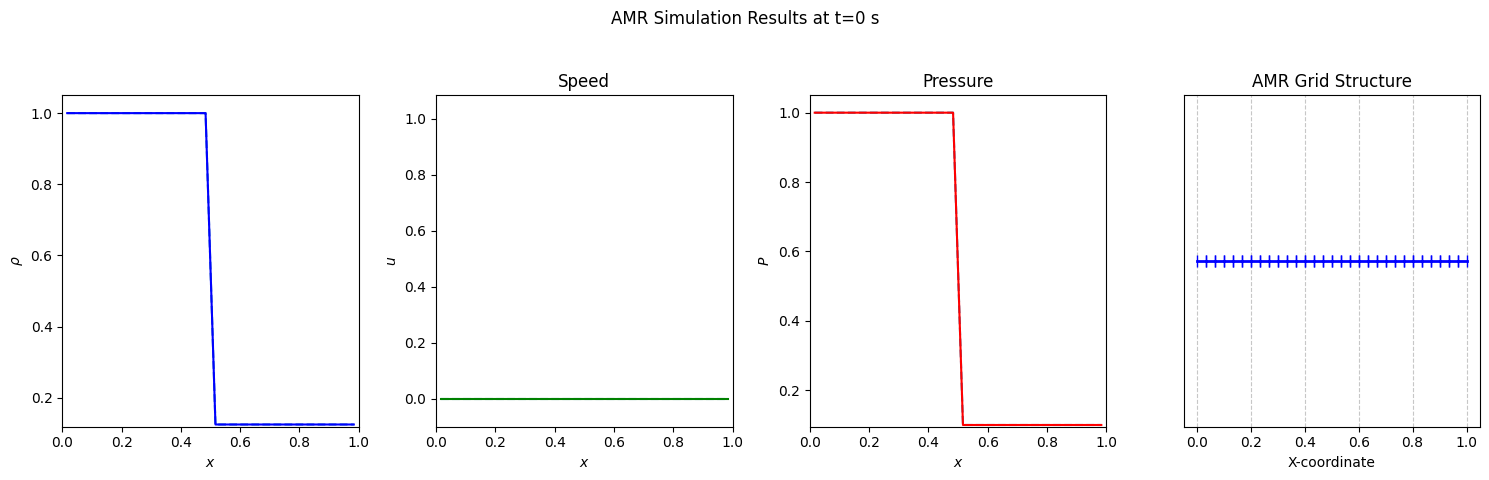

In [ ]:
viz.animate(grid2_history, 'plot/test3.gif', fps=len(grid2_history)/5, analytic=init_con)